In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables
import fbpca

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)


<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [2]:
import datetime
today = datetime.date.today() #.strftime("%y%m%d")

logger = snmcseq_utils.create_logger()

print(today)

2021-01-21


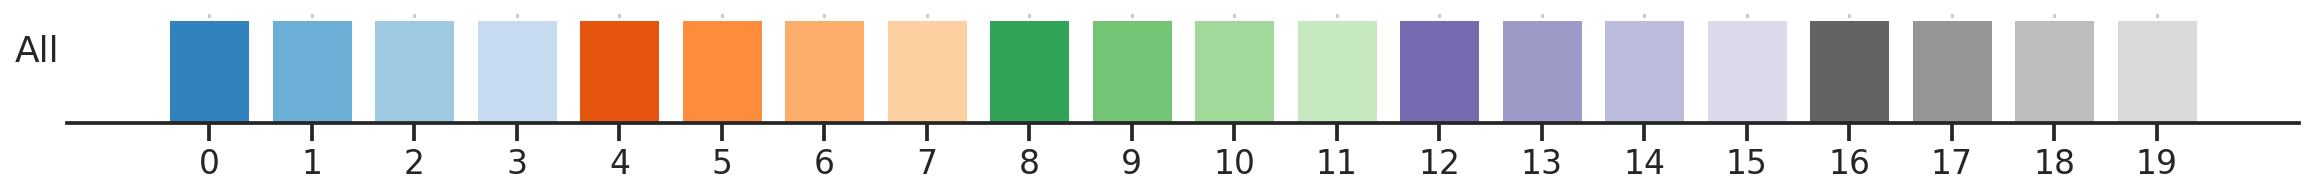

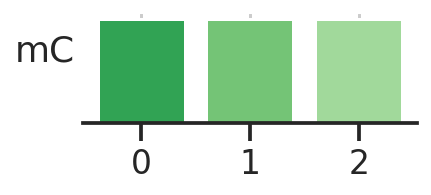

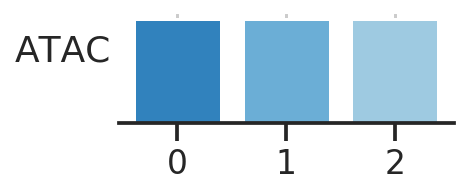

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


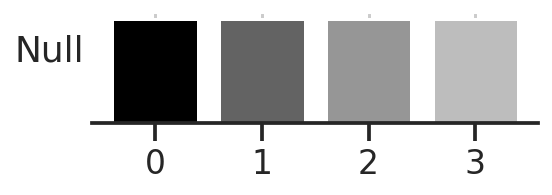

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

## Get gene by metacell tables 
- RNA
- mCG
- ATAC

In [4]:

CLUSTER_COL = 'cluster_r'

def pipe_corr_analysis_atac(
        common_modx_cells, common_mody_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes, common_enhancer_regions,
        X, Y, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_modx_cells_updated = np.intersect1d(common_modx_cells, cell_cell_knn_xaxis)
    common_mody_cells_updated = np.intersect1d(common_mody_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_modx_cells, common_modx_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mody_cells, common_mody_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y = Y.tocsc()[:, y_idx]

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_modx_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mody_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_modx_cells_updated)

    logging.info("{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y.shape,))

    for clst_col in modx_clsts.columns: 
        logging.info(clst_col)
        if clst_col.startswith(CLUSTER_COL):
    #         output_corr = output_corrs.format(clst_col)
    #         if not force and os.path.isfile(output_corr):
    #             logging.info("skip {}, already exists...".format(output_corr))
    #             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))
                continue
            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # Dec 21,2020
            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # Dec 21,2020
            enh_lengths = pd.Series((common_enhancer_regions['end']-common_enhancer_regions['start']).values)
            # enhancer by metacell (counts)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_atac = Y.dot(knn_yz).todense() 
            # normalization (logTPM)
            ec_atac = snmcseq_utils.logtpm(pd.DataFrame(ec_atac), enh_lengths).values
            logging.info("{} {}".format(gc_rna.shape, ec_atac.shape,))

    #         # corr analysis
    #         output_corr = output_corrs.format(clst_col)
    #         (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    #             gc_rna, ec_atac, 
    #             common_genes, np.arange(len(ec_atac)),
    #             enhancer_gene_to_eval['gene'].values, 
    #             enhancer_gene_to_eval['ens'].values, 
    #             output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
    #             )
            return (
                gc_rna, ec_atac, 
                common_genes, np.arange(len(ec_atac)),
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
            )

def wrap_corr_analysis_atac(
        mod_x, mod_y, 
        input_name_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snatac_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_snatac_gene.npz',
    )


    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_modx_cells, common_mody_cells, 
     common_genes, common_enhancer_regions,
     X, Y, 
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(modx_clsts.shape, knn_xy.shape, 
                                          cell_cell_knn_xaxis.shape, 
                                          cell_cell_knn_yaxis.shape,
                                         )
                    )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

    return pipe_corr_analysis_atac(
                common_modx_cells, common_mody_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes, common_enhancer_regions,
                X, Y, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

def pipe_corr_analysis_mc(
        common_rna_cells, common_mc_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes,
        X, Y_cg, Y_mcg, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
    common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y_cg = Y_cg.tocsc()[:, y_idx]
    Y_mcg = Y_mcg.tocsc()[:, y_idx] 

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_rna_cells_updated)

    logging.info("{}_{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y_cg.shape, Y_mcg.shape))

    for clst_col in modx_clsts.columns: 
        if clst_col.startswith(CLUSTER_COL):
            
            logging.info(clst_col)
        
#         output_corr = output_corrs.format(clst_col)
#         if not force and os.path.isfile(output_corr):
#             logging.info("skip {}, already exists...".format(output_corr))
#             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))

            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # # normalization - such that metacells made of more cells still sums to 1
            # knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))
            # # gene by metacell
            # gc_rna = X.dot(knn_xz).todense() 

            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # enhancer by metacell (counts cg, mcg)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_cg = Y_cg.dot(knn_yz).todense() 
            ec_mcg = Y_mcg.dot(knn_yz).todense()  
            logging.info("{} {} {}".format(gc_rna.shape, ec_cg.shape, ec_mcg.shape))

            # mC
            ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                           pd.DataFrame(ec_cg).astype(np.float32), 
                                           pd.DataFrame(ec_mcg).astype(np.float32), 
                                           base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
            logging.info("{}".format(ec_mccg.shape))

#             # corr analysis
#             (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
#                 gc_rna, ec_mccg, 
#                 common_genes, ec_mccg.index.values,
#                 enhancer_gene_to_eval['gene'].values, 
#                 enhancer_gene_to_eval['ens'].values, 
#                 output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
#                 )
            return (
                gc_rna, ec_mccg, 
                common_genes, ec_mccg.index.values,
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
                )

def wrap_corr_analysis_mc(
        mod_x, mod_y, 
        input_nme_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snmcseq_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_mcg_snmcseq_gene.npz',
        'mat_cg_snmcseq_gene.npz',
    )

    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_rna_cells, common_mc_cells, 
     common_genes, common_enhancer_regions,
     X, Y_mcg, Y_cg, 
    #  knn_xy, knn_xx,
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(
              modx_clsts.shape, 
              knn_xy.shape, 
              cell_cell_knn_xaxis.shape, 
              cell_cell_knn_yaxis.shape,
              )
             )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
    return pipe_corr_analysis_mc(
                common_rna_cells, common_mc_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes,
                X, Y_cg, Y_mcg, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

In [5]:
mod_x, mod_y = '10x_cells_v3', 'snatac_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'

CLUSTER_COL = 'cluster_r25'
res1 = wrap_corr_analysis_atac(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
                            corr_type='spearmanr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna1, ec_atac = res1[:2]
print(gc_rna1.shape, ec_atac.shape)

mod_x, mod_y = '10x_cells_v3', 'snmcseq_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'
res2 = wrap_corr_analysis_mc(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
    #                         corr_type='pearsonr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna2, ec_mccg = res2[:2]
print(gc_rna2.shape, ec_mccg.shape)

01/21/2021 12:21:25 AM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
01/21/2021 12:21:25 AM <class 'numpy.ndarray'>_(135665,)_cell_snatac_gene.txt
01/21/2021 12:21:25 AM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
01/21/2021 12:21:25 AM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
01/21/2021 12:21:28 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
01/21/2021 12:21:28 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 135665)_mat_snatac_gene.npz
01/21/2021 12:21:29 AM (55862, 41) (55862, 43774) (55862,) (43774,)
01/21/2021 12:21:38 AM (55862, 43774)_(55862, 41)_(31053, 55862)_(233514, 43774)
01/21/2021 12:21:38 AM cluster_r1.0
01/21/2021 12:21:38 AM cluster_r1.2589254117941673
01/21/2021 12:21:38 AM cluster_r1.5848931924611136
01/21/2021 12:21:38 AM cluster_r1.9952623149688797
01/21/2021 12:21:38 AM cluster_r2.51188643150958
01/21/2021 12:21:38 AM cluster_r3.1622776601683795
01/21/2021 12:21:38 AM cluster_r3.981071705534973
01

(31053, 251) (233514, 251)


01/21/2021 12:21:57 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
01/21/2021 12:21:58 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_mcg_snmcseq_gene.npz
01/21/2021 12:22:00 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_cg_snmcseq_gene.npz
01/21/2021 12:22:01 AM (55912, 41) (55912, 7499) (55912,) (7499,)
01/21/2021 12:22:12 AM (55912, 7497)_(55912, 41)_(31053, 55912)_(233514, 7497)_(233514, 7497)
01/21/2021 12:22:12 AM cluster_r25.11886431509581
01/21/2021 12:22:12 AM Number of metacells: 248
01/21/2021 12:23:00 AM (31053, 248) (233514, 248) (233514, 248)
01/21/2021 12:23:02 AM Imputing data... (No effect if sufficient_coverage_fraction=1)
01/21/2021 12:23:03 AM (233512, 248)


(31053, 248) (233512, 248)


In [6]:
# enhancer_gene_pairs
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
enh_gene_table = pd.read_csv(f, sep='\t')
print(enh_gene_table.shape)

(2589994, 18)


In [7]:
ec_mccg.tail()

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,246,247
233509,0.024564,0.020045,0.754647,0.636523,0.827143,0.880168,0.818412,0.857061,0.929900,0.667137,...,0.793713,0.800481,0.739035,0.822034,0.798982,0.040000,0.808732,0.870712,0.631757,0.750000
233510,0.827608,0.972543,0.996793,0.987494,0.872891,0.920969,0.883171,0.204075,0.925007,0.569387,...,0.524786,0.916499,0.823464,0.303293,0.538686,0.781482,0.904624,0.255034,0.594771,0.476744
233511,0.171004,0.069895,0.978632,0.994764,0.979430,0.971857,0.925962,0.891357,0.965318,0.911102,...,0.937132,0.989209,0.965630,0.981651,0.940803,0.293144,0.961102,0.887755,0.838150,0.830508
233512,0.943284,0.400000,0.989529,1.000000,1.000000,1.000000,1.000000,0.901667,1.000000,1.000000,...,0.909910,1.000000,0.914894,0.930818,0.880000,0.830303,1.000000,0.813433,1.000000,0.923077
233513,0.953065,0.892268,0.999457,1.000000,0.865772,0.650622,0.780350,0.994978,0.791262,0.316273,...,0.943452,0.867647,0.768987,0.949405,0.971503,0.928870,0.650206,0.992509,0.883178,0.837838


## analysis

- make sure enhancer index matches (yes)
- PCA on genes (scree plot)
- remove top ones
- regress RNA ~ mC/ATAC


In [8]:
def eval_scree(s, pcs_to_plot):
    """
    """
    scree = np.power(s, 2)/np.sum(np.power(s, 2))

    fig, ax = plt.subplots(1, 1, figsize=(1*5, 1*5))
    ax.set_title("PC1: {:.3f}".format(scree[0]))
    ax.plot(pcs_to_plot, scree[pcs_to_plot-1], '-o')
    ax.set_xlabel('Principal components')
    ax.set_ylabel('Fraction of variance')
    plt.show()

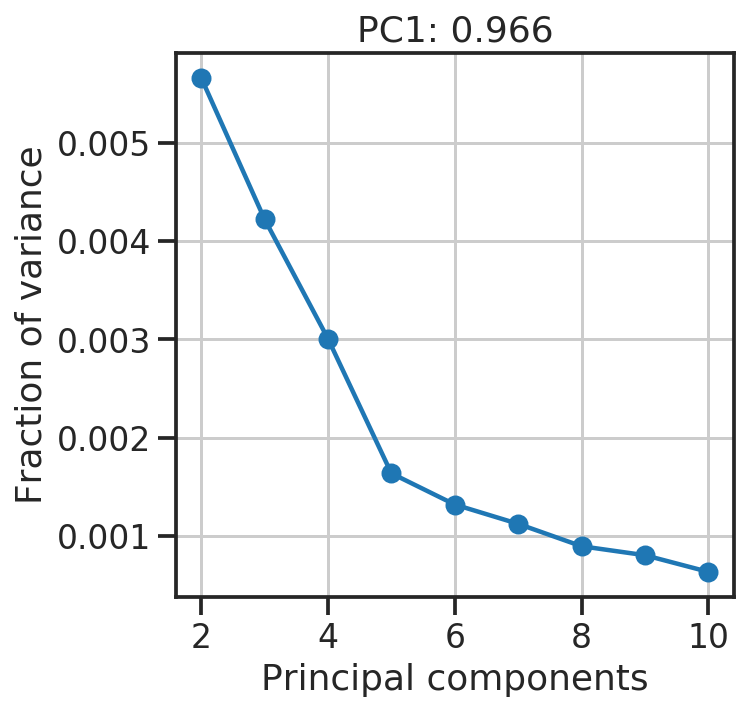

In [9]:
U, s, Vt = fbpca.pca(gc_rna2, k=min(gc_rna2.shape))
pcs_to_plot = np.arange(2, 11, 1)
eval_scree(s, pcs_to_plot)

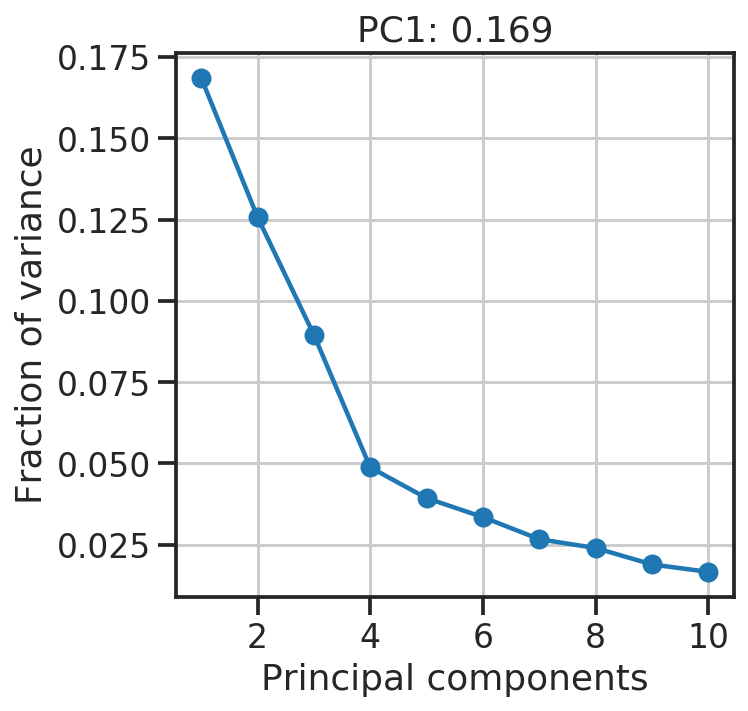

In [10]:
# remove PC1
gc_rna_res2 = gc_rna2 - np.dot(U[:,[0]]*s[0], Vt[[0],:])
U, s, Vt = fbpca.pca(gc_rna_res2, k=min(gc_rna_res2.shape))
pcs_to_plot = np.arange(1, 11, 1)
eval_scree(s, pcs_to_plot)

In [33]:
# regression (applied to each gene and enh pair) -- correlate gene-enh

# # corr analysis
output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/'
               'test_pca_normal_mcrna_jan20.pkl'
              )
(to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    gc_rna2, ec_mccg, 
    res2[2], res2[3],
    res2[4], res2[5],
    output_file=output_file, corr_type='spearmanr',
)

to_evals = enh_gene_table
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

spearmanr chosen!
0 0.001951456069946289
100000 0.26044416427612305
200000 0.5142590999603271
300000 0.7625222206115723
400000 1.0080840587615967
500000 1.25905179977417
600000 1.5031180381774902
700000 1.7506647109985352
800000 1.9958033561706543
900000 2.243818521499634
1000000 2.492525815963745
1100000 2.7449452877044678
1200000 2.9913175106048584
1300000 3.2381536960601807
1400000 3.4841504096984863
1500000 3.731339693069458
1600000 3.9807894229888916
1700000 4.233837842941284
1800000 4.489436388015747
1900000 4.7419774532318115
2000000 4.994319200515747
2100000 5.245389699935913
2200000 5.4981162548065186
2300000 5.749629020690918
0 0.0019142627716064453
100000 0.2612903118133545
200000 0.520646333694458
300000 0.773144006729126
400000 1.0229601860046387
500000 1.2734391689300537
600000 1.525181531906128
700000 1.779477834701538
800000 2.0290679931640625
900000 2.278799533843994
1000000 2.52897572517395
1100000 2.7791130542755127
1200000 3.0356173515319824
1300000 3.29647469520568

In [34]:
# regression (applied to each gene and enh pair) -- correlate gene-enh

# # corr analysis
output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/'
               'test_pca_residue_mcrna_jan20.pkl'
              )
(to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    gc_rna_res2, ec_mccg, 
    res2[2], res2[3],
    res2[4], res2[5],
    output_file=output_file, corr_type='spearmanr', 
)

to_evals = enh_gene_table
res_corrs_res = to_evals[to_correlate].copy()
res_corrs_res['corr'] = corrs 
res_corrs_res['corr_shuff'] = corrs_shuffled
res_corrs_res['corr_shuff_cells'] = corrs_shuffled_cells

spearmanr chosen!
0 0.008100271224975586
100000 0.2576320171356201
200000 0.510875940322876
300000 0.756096601486206
400000 0.9997375011444092
500000 1.24345064163208
600000 1.4863781929016113
700000 1.7291510105133057
800000 1.9709303379058838
900000 2.212655544281006
1000000 2.4541962146759033
1100000 2.6961889266967773
1200000 2.9432268142700195
1300000 3.1911838054656982
1400000 3.444030284881592
1500000 3.6921050548553467
1600000 3.942553997039795
1700000 4.196178913116455
1800000 4.449906587600708
1900000 4.703389883041382
2000000 4.9558265209198
2100000 5.207386016845703
2200000 5.461578130722046
2300000 5.713516712188721
0 0.0023136138916015625
100000 0.2628207206726074
200000 0.5257806777954102
300000 0.7805619239807129
400000 1.0323536396026611
500000 1.2837584018707275
600000 1.5365424156188965
700000 1.7887547016143799
800000 2.0401804447174072
900000 2.2913947105407715
1000000 2.5428922176361084
1100000 2.7943129539489746
1200000 3.053098678588867
1300000 3.312311887741089

In [35]:
# regression (applied to each gene and enh pair) -- correlate gene-enh

# # corr analysis
output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/'
               'test_pca_normal_pearsonr_mcrna_jan20.pkl'
              )
(to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    gc_rna2, ec_mccg, 
    res2[2], res2[3],
    res2[4], res2[5],
    output_file=output_file, corr_type='pearsonr',
)

to_evals = enh_gene_table
res_corrs_pearsonr = to_evals[to_correlate].copy()
res_corrs_pearsonr['corr'] = corrs 
res_corrs_pearsonr['corr_shuff'] = corrs_shuffled
res_corrs_pearsonr['corr_shuff_cells'] = corrs_shuffled_cells

pearsonr chosen!
0 0.001886606216430664
100000 0.24831223487854004
200000 0.4771401882171631
300000 0.6971256732940674
400000 0.912339448928833
500000 1.1545073986053467
600000 1.4129176139831543
700000 1.6435105800628662
800000 1.8624725341796875
900000 2.081670045852661
1000000 2.299647331237793
1100000 2.5192439556121826
1200000 2.7480249404907227
1300000 2.9830262660980225
1400000 3.2135555744171143
1500000 3.4402658939361572
1600000 3.6860218048095703
1700000 3.9557111263275146
1800000 4.241829872131348
1900000 4.505148410797119
2000000 4.739001989364624
2100000 4.971270561218262
2200000 5.206766128540039
2300000 5.438896179199219
0 0.004448413848876953
100000 0.23384308815002441
200000 0.4615473747253418
300000 0.6798293590545654
400000 0.8958277702331543
500000 1.1099762916564941
600000 1.326427936553955
700000 1.5419178009033203
800000 1.7584941387176514
900000 1.972266674041748
1000000 2.1875720024108887
1100000 2.4020817279815674
1200000 2.6275978088378906
1300000 2.853098869

In [36]:
# regression (applied to each gene and enh pair) -- correlate gene-enh

# # corr analysis
output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/'
               'test_pca_residue_pearsonr_mcrna_jan20.pkl'
              )
(to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    gc_rna_res2, ec_mccg, 
    res2[2], res2[3],
    res2[4], res2[5],
    output_file=output_file, corr_type='pearsonr', 
)

to_evals = enh_gene_table
res_corrs_res_pearsonr = to_evals[to_correlate].copy()
res_corrs_res_pearsonr['corr'] = corrs 
res_corrs_res_pearsonr['corr_shuff'] = corrs_shuffled
res_corrs_res_pearsonr['corr_shuff_cells'] = corrs_shuffled_cells

pearsonr chosen!
0 0.0018911361694335938
100000 0.22373700141906738
200000 0.4456057548522949
300000 0.658825159072876
400000 0.8706326484680176
500000 1.0922393798828125
600000 1.3407418727874756
700000 1.5786328315734863
800000 1.792806625366211
900000 2.0040457248687744
1000000 2.218548536300659
1100000 2.4302382469177246
1200000 2.6525635719299316
1300000 2.873361587524414
1400000 3.0931460857391357
1500000 3.3122212886810303
1600000 3.5364279747009277
1700000 3.7704355716705322
1800000 4.0131566524505615
1900000 4.2780210971832275
2000000 4.5225536823272705
2100000 4.766632318496704
2200000 5.002052545547485
2300000 5.227779388427734
0 0.0045964717864990234
100000 0.23435378074645996
200000 0.46708011627197266
300000 0.6887855529785156
400000 0.9060828685760498
500000 1.123790979385376
600000 1.3448033332824707
700000 1.5635395050048828
800000 1.7808513641357422
900000 1.999504566192627
1000000 2.2176132202148438
1100000 2.435044288635254
1200000 2.6625187397003174
1300000 2.89416

In [29]:
def plot_routine(res_corrs1, res_corrs2, title1, title2, ylim=[]):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    bins = np.linspace(-1, 1, 201)
    fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharex=True, sharey=True)
    for j, (res_corrs, title) in enumerate(zip([res_corrs1, res_corrs2], 
                                             [title1, title2],
                                        )):
        KB = 1000
        labels_base = [
                  'shuffled cell types',
                  'shuffled regions',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+' mCG-RNA' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
        # vertical_lines = [
        #     res_stats['r_th_linked'],
        #     res_stats['r_th_correlated_left'],
        #     res_stats['r_th_correlated_right'],
        # ]
    
        ax = axs[j]
        for i, track in enumerate(corr_tracks):
            ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
        _handles, _labels = ax.get_legend_handles_labels()
        _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
        
        if len(ylim) > 0:
            ax.set_ylim(ylim)
        
        sns.despine(ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Spearman correlation')
        ax.set_ylabel('Density')
        
        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    plt.show()
    

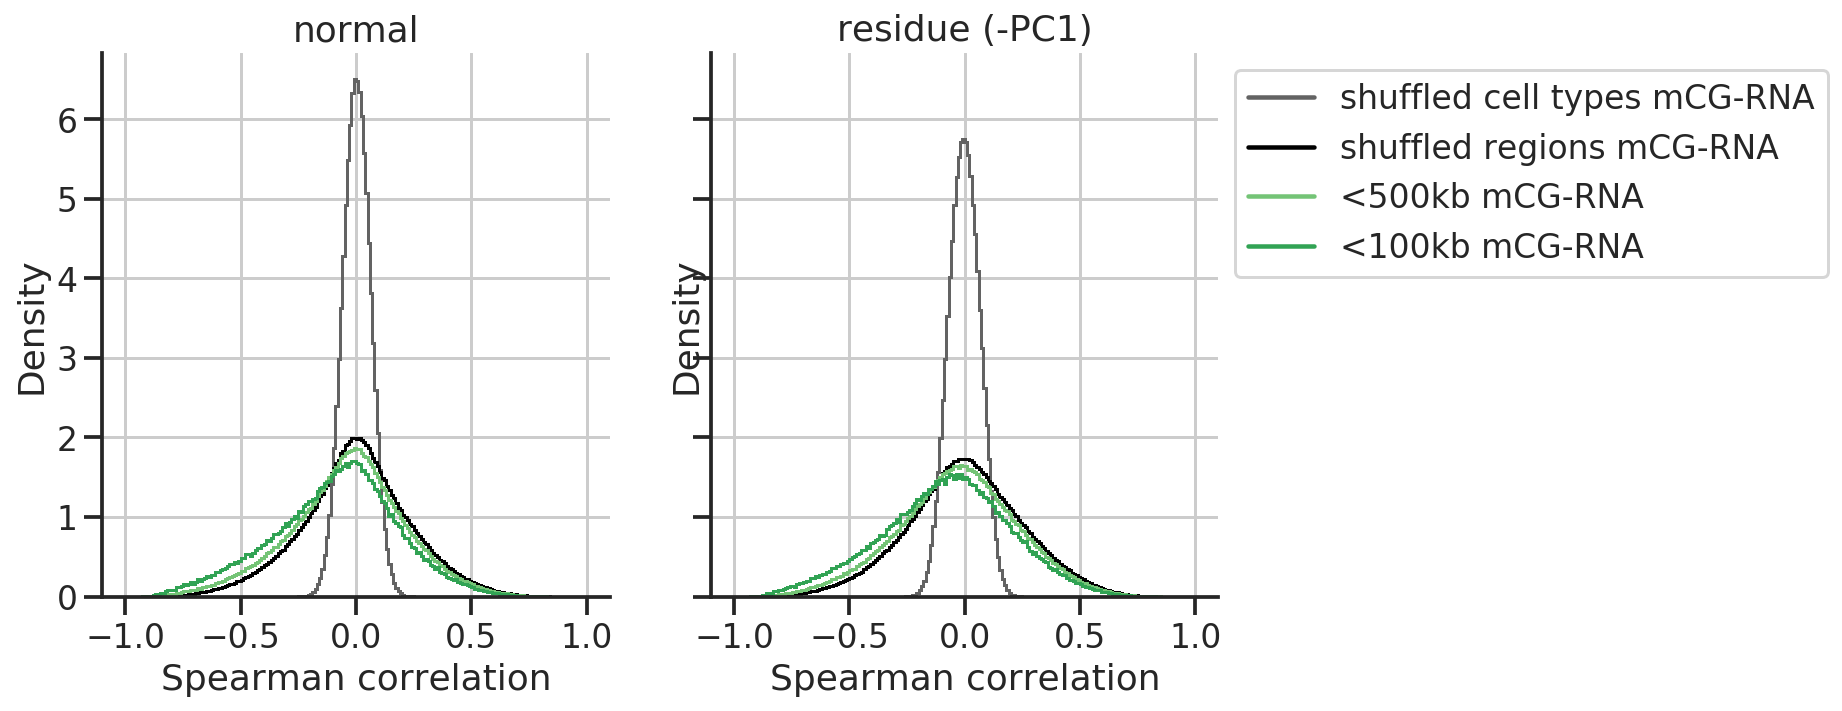

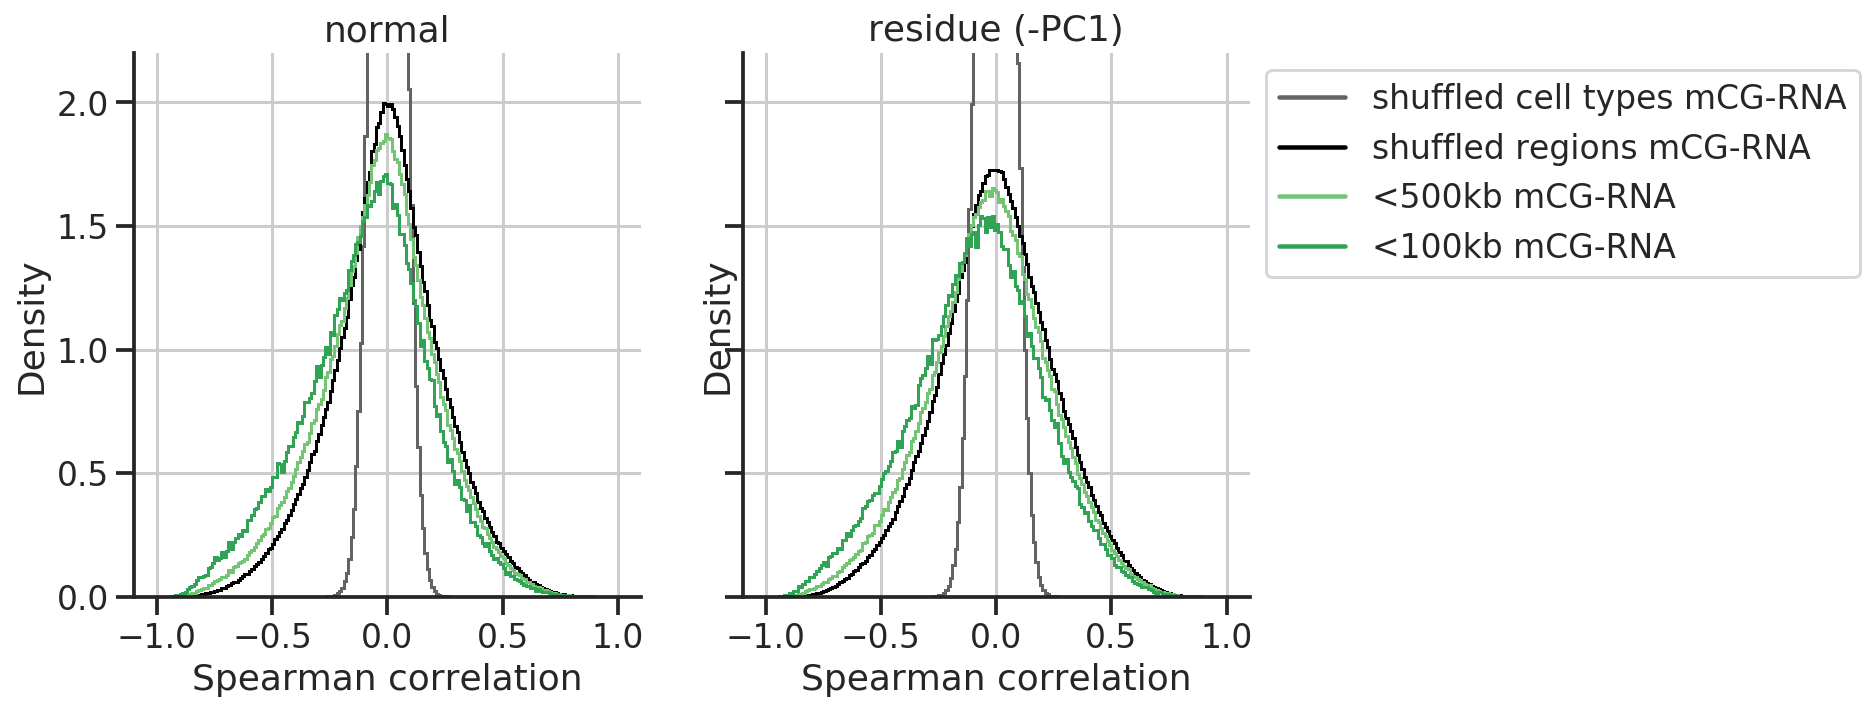

In [31]:
plot_routine(res_corrs, res_corrs_res, 'normal', 'residue (-PC1)', ylim=[])
plot_routine(res_corrs, res_corrs_res, 'normal', 'residue (-PC1)', ylim=[0,2.2])

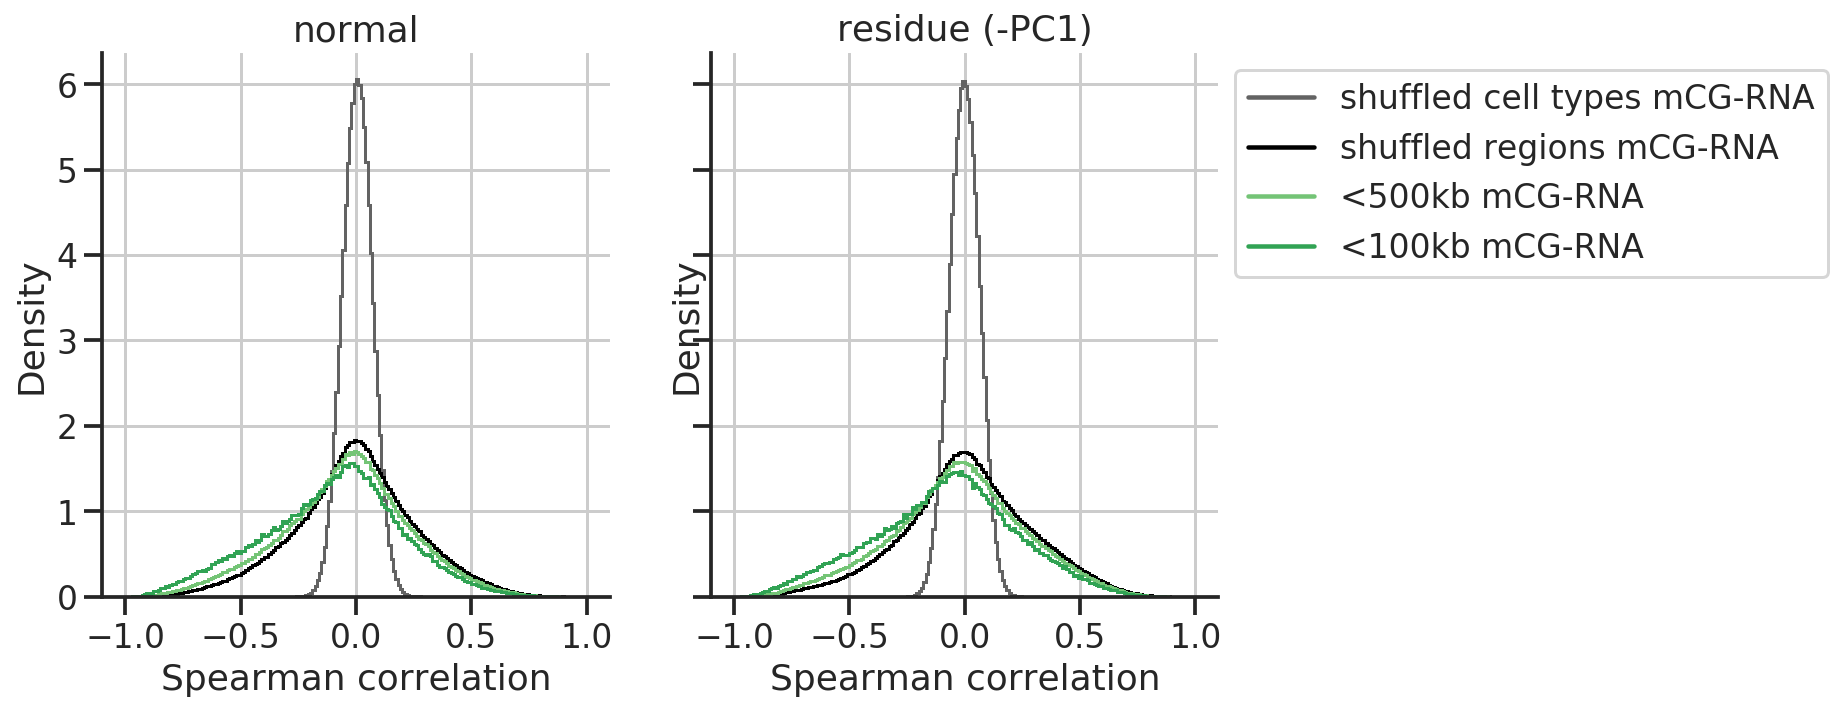

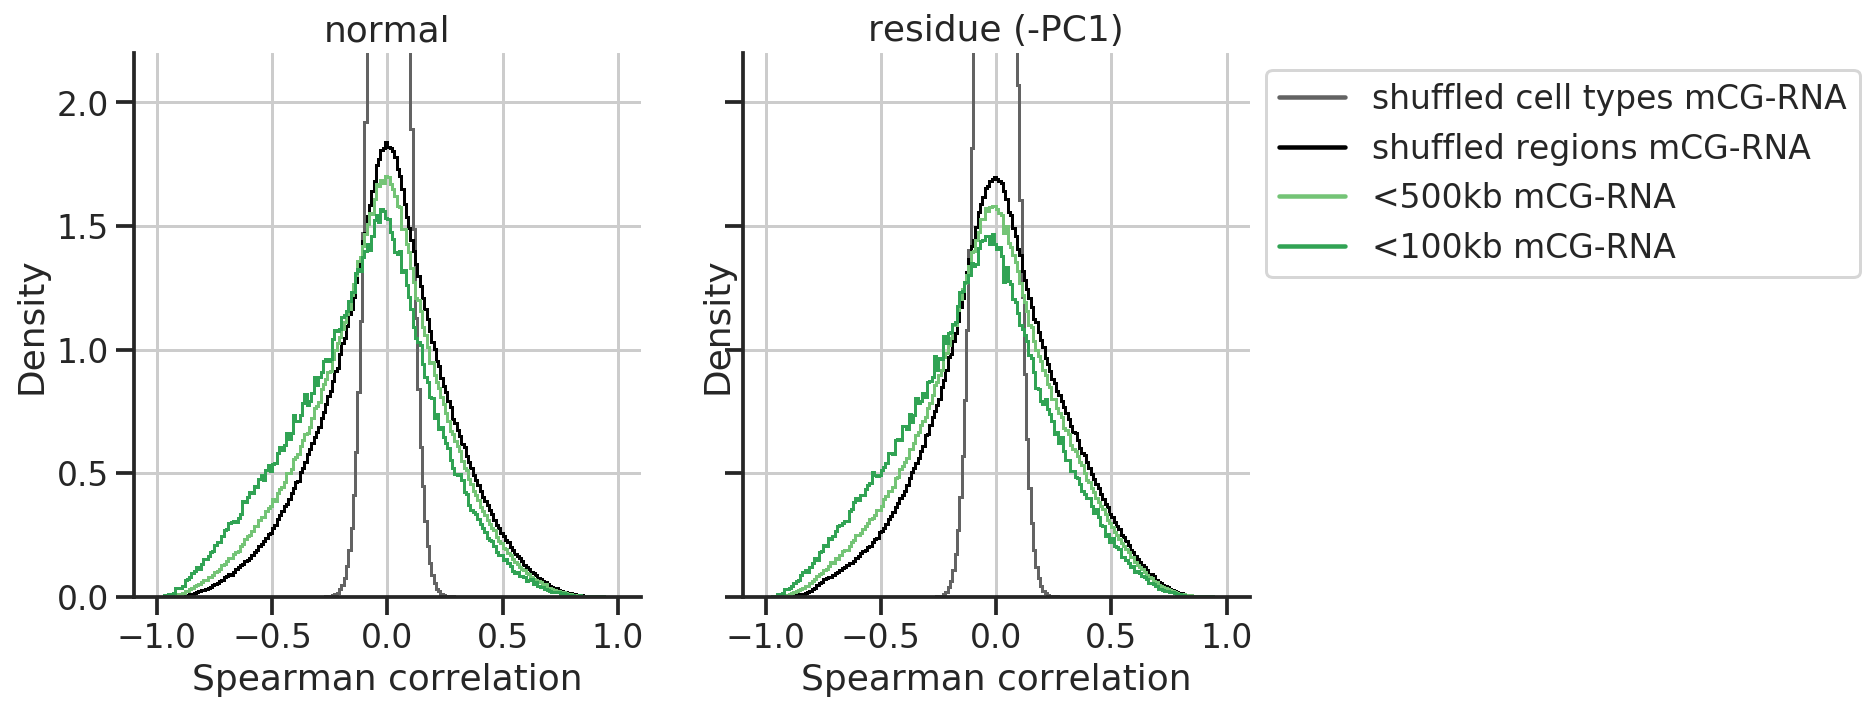

In [37]:
plot_routine(res_corrs_pearsonr, res_corrs_res_pearsonr, 'normal', 'residue (-PC1)', ylim=[])
plot_routine(res_corrs_pearsonr, res_corrs_res_pearsonr, 'normal', 'residue (-PC1)', ylim=[0,2.2])